## CS 506 Lab 06: Kaggle Competition with a Guide

In this lab, you will be learning how to make a valid Kaggle submission for the competition [CS506 Lab: Defective Cookie Detection](https://www.kaggle.com/competitions/cs506-lab-defective-cookie-detection/)

We will be using a Decision Tree Classifier to make our predictions. We will be using the [scikit-learn](https://scikit-learn.org/stable/) library to implement our classifier.

## Getting Started

We will first retrieve the train and test data.

In [4]:
#getting train and test data
import pandas as pd

train_data = pd.read_csv('cookie_train.csv')
test_data = pd.read_csv('cookie_test.csv')

#let's see what we have

train_data.head()

,Id,Texture Hardness,Texture Chewiness,Texture Crispiness,Color L*,Color a*,Color b*,Taste Sweetness,Taste Saltiness,Taste Bitterness,Shape Diameter,Shape Thickness,Smell Intensity,Smell Complexity,Smell Specific Compound,Detected Chemical,Defective
0,59,120,0.05,1.2,80,20,40,2.0,0.5,0.10,6.0,0.5,1.0,10,5,Ethyl butyrate,0
1,60,150,0.08,1.4,85,23,43,3.0,0.6,0.20,5.5,0.6,0.9,12,6,Limonene,1
2,61,135,0.06,1.3,82,22,42,2.5,0.3,0.30,6.2,0.4,0.8,8,4,?-Pinene,0
3,62,100,0.02,1.0,75,18,38,1.5,0.2,0.05,7.0,0.7,0.7,7,3,Linalool,1
4,63,145,0.07,1.5,87,25,45,3.5,0.8,0.15,5.8,0.5,0.9,13,7,?-Caryophyllene,1


In [88]:
# to encode Detected Chemical Column

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoder.fit(train_data['Detected Chemical'])

encoded_data = encoder.transform(train_data['Detected Chemical'])

train_data['Detected Chemical'] = encoded_data

encoder.fit(test_data['Detected Chemical'])

encoded_data = encoder.transform(test_data['Detected Chemical'])

test_data['Detected Chemical'] = encoded_data


So for Kaggle  competitions **for classification**, the submission file should be a csv file with the following format:

| Id | Category |
|----|----------|
| 1  | ?        |
| 2  | ?        |
| ...  | ...        |
| N  | ?        |


Where `Id` is the index of the cookie and `Category` is the predicted category of the cookie.
 **The kaggle competition page will tell you what the desired format will be for other competitions like the Midterm, but the one I described here is for this competition.**

This is what we desire to make to submit to Kaggle.

## Abstracting Features

We can look around and see what features (e.g. `Texture Hardness`) we would want to use in our model to be investigated. To be simple, let us just use the `Texture Hardness` and `Smell Intensity` features. You would want to use more features in your model, but for simplicity, we will just use these two features. Also notice the `string` data type `Detected Chemical`! To use this, we would have to quantify it somehow (This is up to you!)

In [126]:
# to find the most related features
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

X = train_data.drop('Defective', axis=1) # Features
# X = train_data.drop('Detected Chemical', axis=1) # Features
y = train_data['Defective'] # Target variable

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Fit the model to the data
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame with feature importances
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Print the sorted feature importances
print(feature_importances)

                    feature  importance
15        Detected Chemical    0.099707
2         Texture Chewiness    0.099065
1          Texture Hardness    0.098394
13         Smell Complexity    0.093884
4                  Color L*    0.084717
10           Shape Diameter    0.083189
11          Shape Thickness    0.068289
7           Taste Sweetness    0.056150
8           Taste Saltiness    0.056025
0                        Id    0.051155
6                  Color b*    0.048168
5                  Color a*    0.042053
3        Texture Crispiness    0.034789
9          Taste Bitterness    0.034695
12          Smell Intensity    0.032879
14  Smell Specific Compound    0.016839


In [127]:
#Creating a new dataframe for variables we want to pass into a Decision Tree
#NOTE: keeping Id and Category (aka Defective) column since Kaggle has it in the submission format
features_interested = []
features_interested.append('Detected Chemical')
features_interested.append('Texture Hardness')
features_interested_df = train_data[['Id'] + features_interested + ['Defective']]

features_interested_df.head()

,Id,Detected Chemical,Texture Hardness,Defective
0,59,12,120,0
1,60,16,150,1
2,61,6,135,0
3,62,17,100,1
4,63,3,145,1


We may also want to graph things to see how a feature behaves. This can be useful to see pattern and trends in the data, which could yield intuitions on whether something is defective or not.

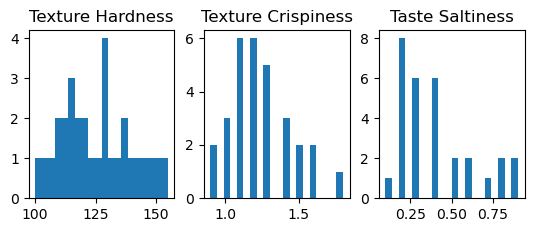

In [30]:
#Plotting distribution of the features we just created

import matplotlib.pyplot as plt

for i, feature in enumerate(features_interested):
    plt.subplot(2, len(features_interested), i+1)
    plt.hist(features_interested_df[feature], bins=20)
    plt.title(feature)
    # plt.show()


## Training the Model

We will now use the Decision Tree to fit our desired features

In [128]:
# for improving the accuracy cross validation and splitting of sets
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(features_interested_df.drop('Defective', axis=1), features_interested_df['Defective'], test_size=0.2, random_state=42)

# Initialize your decision tree model
clf = DecisionTreeClassifier(random_state=42)


# Use cross-validation to tune your model
scores = cross_val_score(clf, X_train, y_train, cv=5)


clf = clf.fit(features_interested_df[features_interested], features_interested_df['Defective'])

# Print the mean score and standard deviation of the cross-validation scores
print('Mean Accuracy:', scores.mean())
print('Standard Deviation:', scores.std())


Mean Accuracy: 0.59
Standard Deviation: 0.27640549922170504


In [129]:
# to fine tune the hyper paramets 
from sklearn.model_selection import GridSearchCV

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object and fit it to the training data
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy score
print("Best hyperparameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best accuracy score: 0.71


In [130]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#creating a classifier model
clf = DecisionTreeClassifier(criterion=grid_search.best_params_['criterion'], max_depth=grid_search.best_params_['max_depth'], min_samples_split=grid_search.best_params_['min_samples_split'], min_samples_leaf=grid_search.best_params_['min_samples_leaf'])

#training the classifier
clf = clf.fit(features_interested_df[features_interested], features_interested_df['Defective'])

y_pred = clf.predict(features_interested_df[features_interested])

accuracy = accuracy_score(features_interested_df['Defective'], y_pred)

print(accuracy)

#predicting the test data ONLY ON THE FEATURES FITTED ON!
test_data['Defective'] = clf.predict(test_data[features_interested])

#creating a submission file but changing Id and Defective Column names to match Kaggle's submission format
submission_df = test_data[['Id', 'Defective']]

#adjusting the column names to satisfy Kaggle submission format
submission_df.columns = ['Id', 'Category']

#saving the submission file
submission_df.to_csv('submission.csv', index=False)

0.9666666666666667


## Testing our Model

We would now have to predict the `Defective` value for each cookie. What we can do here is predict it on the training set. This will give us a sense of how accurate our model is, since we are actually given whether a cookie is `Defective` or not in the training set. You would have this too in the testing set, except for the fact this is a competition so you won't know what they are :). Instead, your accuracy will show on the leaderboard when you submit it. 

Once again, be sure to check it with the training set first before you submit, since submissions per day are limited.

Let us now view what the submission file or our predictions looks like.

In [18]:
submission_df.head(10)

,Id,Category
0,22,0
1,23,1
2,24,1
3,25,1
4,26,1
5,27,0
6,28,1
7,29,1
8,30,1
9,31,0


And now, let us see what the accuracy is using the same accuracy metric on the Kaggle competition made for this lab: Classification Accuracy

In [19]:
#And now, let us see what the accuracy is using the same accuracy metric on the Kaggle competition made for this lab: Classification Accuracy

predicted_train_data = clf.predict(features_interested_df[features_interested])

#Now we can calculate the accuracy of the model
from sklearn.metrics import accuracy_score

print("Accuracy of the model is: " + str(100*accuracy_score(train_data['Defective'], predicted_train_data)) + "%")

Accuracy of the model is: 100.0%


There are other ways to look at accuracy including a confusion matrix:

<AxesSubplot: >

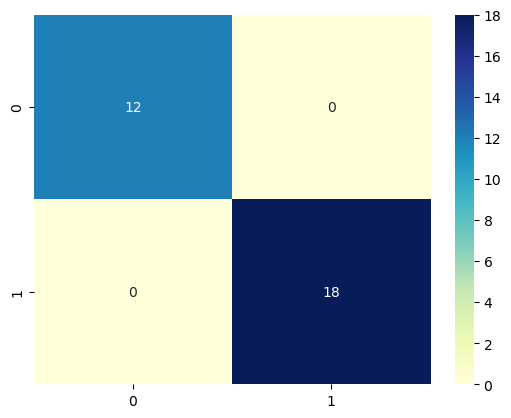

In [20]:
#Creating a confusion matrix where the number is shaded darker the more it is predicted
from sklearn.metrics import confusion_matrix

confusion_matrix(train_data['Defective'], predicted_train_data)

#plotting it with color
import seaborn as sns

sns.heatmap(confusion_matrix(train_data['Defective'], predicted_train_data), annot=True, cmap="YlGnBu")

This seems pretty good! Good enough to submit to Kaggle? Let's see!

## Take the CSV and Submit to Kaggle!

Just as said, locate the `submission.csv` file that would be in the same file path as this notebook and submit it to Kaggle!